In [1]:
import pandas as pd
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
import numpy as np
import requests
from urllib.parse import urlencode

Подгрузим датафреймы. Так как файлы публичные, то **API ключ не нужен** - Яндекс позволяет их скачивать свободно.

In [2]:
urls = [
    'https://disk.yandex.ru/d/UhyYx41rTt3clQ',   # Gropus
    'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',   # groups add
    'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',   # active studs
    'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'    # checks
]  

seps = [';', ',', ';', ';']


def initial_read(url_lst=urls, sep_lst=seps):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    df_list = []
    for i in range(4):
        url = base_url + urlencode(dict(public_key=url_lst[i]))
        response = requests.get(url)
        download_url = response.json()['href']
        df = pd.read_csv(filepath_or_buffer=download_url, sep=sep_lst[i])
        df_list.append(df)
    global df_g, df_ga, df_as, df_c 
    df_g = df_list[0]   # Gropus
    df_ga = df_list[1]  # groups add
    df_as = df_list[2]  # active studs
    df_c = df_list[3]   # checks

initial_read()

(Предварительный EDA)

In [3]:
print(df_as.shape[0])
df_as.head()

8341


,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [4]:
print(df_c.shape[0])
df_c.head()

541


,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [5]:
print(df_ga.shape[0])
df_ga.head()

92


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [6]:
print(df_g.shape[0])
df_g.head()

74484


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Проверим таблицы на баги. Есть ли в чеках, айди студентов, которые не попали в cписок активных студентов?

In [7]:
print(df_c[~df_c['student_id'].isin(df_as.student_id)].shape[0])  # Неактивные
df_c[df_c['student_id'].isin(df_as.student_id)].shape[0]  # активные

149


392

Таких записей почти треть.

NB! Последующие методы исключают эих студентов, учитывая фильтрацию и merge слева. Но полезно отметить как факт, с точки зрения EDA.

Все "неактивные" платящие студенты есть в группах. Т.о. скорее всего это ошибка составления списка Active students. Включить в анализ эти записи мы никак не можем, поскольку не известно, сколько не заплативших не попало в список активных, заходя при этом на платформу. Будем исходить из того, что ошибка происходит независимо от факта оплаты, то есть потеряно 30% заплативших и 30% не заплативших 

In [8]:
df_c_bug = df_c[~df_c['student_id'].isin(df_as.student_id)]
df_c_bug[df_c_bug['student_id'].isin(df_g.id)].shape[0]

149

На последок посмотрим распределение "аутсайдеров" по группам. Забегая вперед, можно сказать, что оно примерно такое же как и в оставшейся группе.

In [9]:
df_c_bug.merge(df_g, how='left', left_on='student_id', right_on='id').groupby('grp', as_index=False).count()

,grp,student_id,rev,id
0,A,29,29,29
1,B,120,120,120


## Задание 1

Выбокри из сравниваемых групп будут формироваться только для активных студентов - так как речь идет о нововведении в сфере оплаты, то не зашедшие скорее всего даже не знают о его существовании.

In [10]:
df_gr = pd.concat([df_g, df_ga], ignore_index=True)  # Сразу подтянем доп. датафрейм.
df_gr_as = df_gr[df_gr['id'].isin(df_as.student_id)]  # Оставим только активных студентов
df_gr

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [11]:
df_c = df_c.rename(columns={'student_id': 'id'})  # Переименум колонку с id в чеках
df_gr_as1 = df_gr_as.merge(df_c, how='left', on='id')  # Добавим чеки
df_gr_as1.rev.count()

392

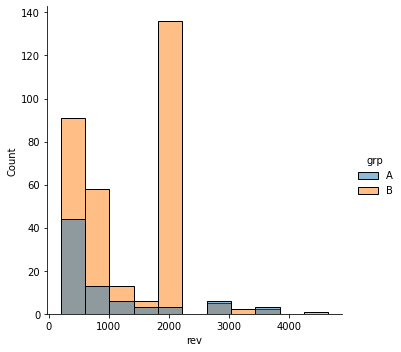

In [12]:
sns.displot(data=df_gr_as1, x='rev', hue='grp')  # Посмотрим распределения по чекам для групп

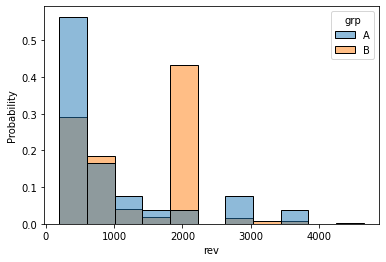

In [13]:
sns.histplot(data=df_gr_as1, x='rev', hue='grp', stat='probability', common_norm=False)  # они же - нормализованные

Выдвинем 2 нулевых гипотезы:
    1. Конверсия в целевой группе не отличается от контрольной 
    2. Средняя выручка на покупателя в группах не отличается.
Первую гипотезу будет удобно проверить при помощи критерия &chi;-квадрат.
Вторую можно проверить при помощи t-криетерия Стьюдента.

In [14]:
df_gr_as1.groupby('grp').count()  # первая колонка - всего, вторая - купили 

,id,rev
grp,,
A,1538,78
B,6803,314


In [15]:
exp = [round((6803) / (1538) * (1538 - 78)), round((6803) / (1538) * 78)]  # ожидаемое [купили, не купили].
obs = [6803 - 314, 314]  # Наблюдаемое
sc.stats.chisquare(exp, obs)

Power_divergenceResult(statistic=3.2086063333048678, pvalue=0.07325185289471631)

Наблюдаемые различия в конверсиях не являются стат значимыми. Нет оснований отвергнуть нулевую гипотезу 1.

Теперь проверим гипотезу 2:

In [16]:
Abuyer = df_gr_as1[(df_gr_as1['grp'] == 'A') & (~df_gr_as1.rev.isnull())].rev  # Покупатели в группе А(контроль)
Bbuyer = df_gr_as1[(df_gr_as1['grp'] == 'B') & (~df_gr_as1.rev.isnull())].rev  # Покупатели в группе В(тест)

print(sc.stats.ttest_ind(Abuyer.values, Bbuyer.values))

print('A mean = ', end='')
print(Abuyer.mean(), end='')
print('±', end='')
print(2 * sc.stats.sem(Abuyer.values))
print('B mean = ', end='')
print(Bbuyer.mean(), end='')
print('±', end='')
print(2 * sc.stats.sem(Bbuyer.values))

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)
A mean = 933.5897435897435±208.3237363705694
B mean = 1257.8789920382164±89.26210371556901


Критерий Левена говорит о незначимых различиях в дисперсиях. Сильных выбросов также не наблюадется, поэтому т-тест корректен.

In [17]:
print('variation A = ', end='')
print(sc.stats.variation(Abuyer.values))
print('variation B = ', end='')
print(sc.stats.variation(Bbuyer.values))

sc.stats.levene(Abuyer.values, Bbuyer.values)

variation A = 0.9790346242832775
variation B = 0.6277264479491601


LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

Нулевая гипотеза о равенстве средних чеков отклоняется. Чек в груупе B в срденем выше.

Учитывая ненормальность распределения...

In [18]:
print('normal test for A:', end='')
print(sc.stats.normaltest(Abuyer.values))
print('normal test for B:', end='')
print(sc.stats.normaltest(Bbuyer.values))

normal test for A:NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)
normal test for B:NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)


...дополнительно проверим наши распеределения методом Bootstrap. Распределения средних с доверительным интервалом 95% не пересекаются, что подтверждает статзначимые различия.  
NB! Учитывая монетраность рассчитываемых метрик, нас интересует именно **среднее** (мат. ожидание).

In [30]:
data = (Abuyer.values, )
print('for A:', end='')
print(sc.stats.bootstrap(data, statistic=np.mean))
data2 = (Bbuyer.values, )
print('for B:', end='')
print(sc.stats.bootstrap(data2, statistic=np.mean))


for A:BootstrapResult(confidence_interval=ConfidenceInterval(low=754.1743444021093, high=1165.1317936104551), standard_error=102.94269251032497)
for B:BootstrapResult(confidence_interval=ConfidenceInterval(low=1173.6374650300813, high=1347.3385246259174), standard_error=44.3208429432504)


### Вывод

Учитывая контекст задачи (влияние страницы оплаты) ключевая метрика эффектиности - ARPAU является произведением конверсии активных пользователей и среднего чека (платящих клиентов).  
В целевой группе средняя выручка по выборке покупателей статзначимо выше - 1257±89 против 934±208.  
Статистически значимых различий в конверсии не обнаружено. Фактические конверсии составили 0.0462 и 0.0507 в тесте и контроле сответственно.  
Доверительные интервалы (95%) для ARPAU 58&plusmn;4 в тестовой против 47&plusmn10 в контрольной.  
Доверительные интервалы для ARPAU пересекаются, что не позволяет говорить о статзначимых различиях в эффективности (по выручке) при критическом p-value = 0.05.  
Таким образом, можно утверждать, что нет стат значимых оснований полагать, что новая платформа повысит выручку, оснований для ее введения недостаточно.

##### Небольшое пояснение.
Несмотря на то, что распределение средних для чека статистически различимы - случай практически пограничный.  
Также, не смотря на то, что разница в конверсии стат не значима, в контроле она чуть больше (на 9%). Таким образом, доверительные интервалы по ARPU уже перекрываются. Если бы мы взяли усредненную конверсию (=0.05), то получили бы ошибку I рода, из-за погрешности округления. На самом деле и у конверсии есть некое стандартное отклонение, что еще сильнее увеличивает доверительный интервал ARPU (как результат произведения двух независимых величин со своими дисперсиями )

## Задание 2.

С запросами можно ознакомится:
    1.https://redash.lab.karpov.courses/queries/55529
    2.https://redash.lab.karpov.courses/queries/55591

## Задание 3.

Функция догрузки.  
Функция загружает доп таблицу по url с Яндекс Диска.  
Для тестирования по умолчанию основной датафрейм - загруженный через initial_read().  
Загружаемый датасет по умолчанию - groups_ad.  
Если например, загружена третья таблица с группами - передать текущую таблицу и новый url, если он был изменен.  
Булевый параметр write если True - дополненная таблица сохранится локально как Groups_total.

In [22]:
def add_func(curr_df=df_g, url_add=urls[1], write=False):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url = base_url + urlencode(dict(public_key=url_add))
    response = requests.get(url)
    download_url = response.json()['href']
    df_ad = pd.read_csv(filepath_or_buffer=download_url)
    
    lst = df_ad.columns.to_list()  # Список с именами, какие бы они не были 
    df_ad = df_ad.rename(columns={lst[0]: 'id', lst[1]: 'grp'})  # переименование колонок догружаемого для конкатенции
    df_tot = pd.concat([curr_df, df_ad], ignore_index=True)  # конкатенция
    
    df_c1 = df_c.copy()
    df_c1 = df_c1.rename(columns={'student_id': 'id'})
    # подгрузка чеков для расчета метрик
    df = df_tot[df_tot['id'].isin(df_as.student_id)].merge(df_c1, how='left', on='id')  
    
    # метрики
    data = {' ': ['Конверсия', 'Средний чек'],
            'A': [df[(df['grp'] == 'A') & (~df['rev'].isnull())].rev.count() / df[df['grp'] == 'A'] \
                  .id.count(), df[(df['grp'] == 'A') & (~df['rev'].isnull())].rev.mean()],
            'B': [df[(df['grp'] == 'B') & (~df['rev'].isnull())].rev.count() / df[df['grp'] == 'B'] \
                  .id.count(), df[(df['grp'] == 'B') & (~df['rev'].isnull())].rev.mean()]
            }
    df_conv = pd.DataFrame(data)
    df_conv = df_conv.set_index(df_conv[' '])
    df_conv = df_conv.drop(columns=[' '])

    display(df_conv)  # вывод метрик
    
    if write:
        df_tot.to_csv('Groups_total.csv', index=False)
    
    return df_tot  # возврат доплненого дф (без чеков)

add_func()

,A,B
,,
Конверсия,0.050715,0.046156
Средний чек,933.589744,1257.878992


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


Функция визуализации.
По умолчанию идет дополненная функция из основного блока.
Для использования в случае с новым дополнениями вызвать функцию add_func(), результат функции передать в graph_plot().

In [ ]:
def graph_plot(df=df_gr):
    df = df[df['id'].isin(df_as.student_id)]  # Оставить только покупателей
    df_c1 = df_c.copy()
    df_c1 = df_c1.rename(columns={'student_id': 'id'})
    df = df.merge(df_c, how='left', on='id')  # Добавить чеки
    bins = int(df.rev.max() // 600)
    sns.displot(data=df, x='rev', hue='grp', bins=bins)  # Распределения
    
    plt.show()
     
    sns.boxplot(y='rev', data=df, x='grp')  # Средние чеки
    plt.title('Средний чек', fontsize=14, fontweight='bold', pad=15)
    
    plt.show()
graph_plot()

Демонстрационная версия скрипта, которая догружает и строит графики - в ветке - add_vis_script.py